####  Installing  Required Libraries

In [1]:
!pip install labelme
!pip install ultralytics
!pip install opencv-python matplotlib
!pip install shapely

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.9 M

#### Importing Libraries

In [2]:
import os
import json
import random
import cv2
import shutil
import uuid
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
from shapely.geometry import Polygon, MultiPolygon
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
%matplotlib inline
import matplotlib.pyplot as plt

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataset= "/content/drive/MyDrive/Shrimp_file/shrimp_segmentation_dataset/shrimp_segmentation_dataset/dataset"
output_dir = "/content/drive/MyDrive/Shrimp_file/output"
os.makedirs(output_dir + "/images", exist_ok=True)
os.makedirs(output_dir + "/annotations", exist_ok=True)

#### Converting LabelMe JSON to COCO Format with Merged Polygons

In [5]:
coco_output = {
    "images": [],
    "annotations": [],
    "categories": [{"id": 0, "name": "shrimp"}]
}

In [6]:
annotation_id = 0
# Get all JSON files in the dataset folder
json_files = [f for f in os.listdir(dataset) if f.endswith(".json")]

for img_id, json_file in enumerate(tqdm(sorted(json_files))):
    json_path = os.path.join(dataset, json_file)
    with open(json_path) as f:
        data = json.load(f)

    image_filename = data['imagePath']
    image_path = os.path.join(dataset, image_filename)

    # Check if image file exists
    if not os.path.exists(image_path):
        print(f"Warning: Image file '{image_filename}' not found for JSON '{json_file}'. Skipping.")
        continue

    image = np.array(Image.open(image_path))
    height, width = image.shape[:2]
    image_id = img_id

    coco_output["images"].append({
        "id": image_id,
        "width": width,
        "height": height,
        "file_name": image_filename
    })

    # Group all shapes by shrimp instance ID
    instance_groups = {}
    for shape in data["shapes"]:
        label = shape["label"]
        group_id = shape.get("group_id") or str(uuid.uuid4())

        if group_id not in instance_groups:
            instance_groups[group_id] = []
        instance_groups[group_id].append(shape["points"])

    for group_id, polygons in instance_groups.items():
        merged_poly = None
        for pts in polygons:
            poly = Polygon(pts)
            if merged_poly is None:
                merged_poly = poly
            else:
                merged_poly = merged_poly.union(poly)

        if not merged_poly.is_valid:
            continue

        segmentation = []
        if isinstance(merged_poly, MultiPolygon):
            for p in merged_poly.geoms:
                segmentation.append(np.array(p.exterior.coords).ravel().tolist())
        else:
            segmentation.append(np.array(merged_poly.exterior.coords).ravel().tolist())

        bbox = merged_poly.bounds
        x_min, y_min, x_max, y_max = bbox
        bbox_width = x_max - x_min
        bbox_height = y_max - y_min
        area = merged_poly.area

        coco_output["annotations"].append({
            "id": annotation_id,
            "image_id": image_id,
            "category_id": 0,
            "segmentation": segmentation,
            "bbox": [x_min, y_min, bbox_width, bbox_height],
            "area": area,
            "iscrowd": 0
        })
        annotation_id += 1


# Save COCO JSON
with open(f"{output_dir}/annotations/instances_all.json", "w") as f:
    json.dump(coco_output, f)

print("✅ Successfully converted LabelMe to COCO format and merged masks.")

 47%|████▋     | 154/325 [00:20<00:10, 15.55it/s]

 53%|█████▎    | 172/325 [00:21<00:07, 20.92it/s]

 55%|█████▌    | 179/325 [00:21<00:06, 21.84it/s]

 57%|█████▋    | 186/325 [00:22<00:06, 21.51it/s]

 58%|█████▊    | 190/325 [00:22<00:06, 20.75it/s]

 61%|██████    | 199/325 [00:22<00:05, 21.94it/s]

 66%|██████▋   | 216/325 [00:23<00:03, 28.62it/s]

 80%|████████  | 261/325 [00:23<00:01, 57.22it/s]

 90%|█████████ | 293/325 [00:23<00:00, 89.55it/s]

100%|██████████| 325/325 [00:28<00:00, 11.60it/s]


✅ Successfully converted LabelMe to COCO format and merged masks.


#### Preparing  YOLOv8 Dataset Structure

In [7]:
# Paths
coco_json = "/content/drive/MyDrive/Shrimp_file/output/annotations/instances_all.json"
image_dir = "/content/drive/MyDrive/Shrimp_file/shrimp_segmentation_dataset/shrimp_segmentation_dataset/dataset"
output_dir = "/content/drive/MyDrive/Shrimp_file/output"

In [8]:
# Creating directory structure
for split in ["train", "val", "test"]:
    os.makedirs(f"{output_dir}/images/{split}", exist_ok=True)
    os.makedirs(f"{output_dir}/labels/{split}", exist_ok=True)

In [9]:
# Loading COCO JSON
with open(coco_json) as f:
    coco_data = json.load(f)

images = coco_data['images']
annotations = coco_data['annotations']

In [10]:
# Building image ID → file_name mapping
img_id_to_file = {img["id"]: img["file_name"] for img in images}

In [13]:
# Spliting dataset
train_imgs, test_imgs = train_test_split(images, test_size=0.2, random_state=42)
val_imgs, test_imgs = train_test_split(test_imgs, test_size=0.5, random_state=42)

In [14]:
# Creating split folders
split_dict = {
    "train": train_imgs,
    "val": val_imgs,
    "test": test_imgs
}

In [15]:
# Building image_id → annotations map
from collections import defaultdict
img_to_annots = defaultdict(list)
for ann in annotations:
    img_to_annots[ann["image_id"]].append(ann)

#### Converting COCO segmentation to YOLOv8 segmentation format

In [16]:
def coco_poly_to_yolo(poly, img_width, img_height):
    norm_coords = []
    for i in range(0, len(poly), 2):
        x = poly[i] / img_width
        y = poly[i+1] / img_height
        norm_coords.append(x)
        norm_coords.append(y)
    return norm_coords

for split, imgs in split_dict.items():
    for img in tqdm(imgs, desc=f"Processing {split}"):
        fname = img["file_name"]
        shutil.copy(os.path.join(image_dir, fname), os.path.join(output_dir, "images", split, fname))

        img_id = img["id"]
        width, height = img["width"], img["height"]
        anns = img_to_annots[img_id]

        label_txt = ""
        for ann in anns:
            for seg in ann["segmentation"]:
                seg = coco_poly_to_yolo(seg, width, height)
                coords = " ".join([f"{x:.6f}" for x in seg])
                label_txt += f"0 {coords}\n"  # class 0 = shrimp

        with open(os.path.join(output_dir, "labels", split, fname.replace(".jpg", ".txt")), "w") as f:
            f.write(label_txt)

print("✅ Annotations converted to YOLO segmentation format.")

Processing test: 100%|██████████| 17/17 [00:10<00:00,  1.57it/s]

✅ Annotations converted to YOLO segmentation format.


#### YAML Configuration for Training

In [17]:
dataset_yaml = """\
path: "/content/drive/MyDrive/Shrimp_file/output/annotations/instances_all.json"
train: "/content/drive/MyDrive/Shrimp_file/output/images/train"
val: "/content/drive/MyDrive/Shrimp_file/output/images/val"
test: "/content/drive/MyDrive/Shrimp_file/output/images/test"

names:
  0: shrimp
"""

with open("/content/drive/MyDrive/Shrimp_file/data.yaml", "w") as f:
    f.write(dataset_yaml)

print("✅ YOLOv8 config file created.")

✅ YOLOv8 config file created.


#### Training the YOLOv8-seg Model

In [18]:
# Loading YOLOv8-seg model (pretrained)
model = YOLO("yolov8n-seg.pt")

100%|██████████| 6.74M/6.74M [00:00<00:00, 104MB/s]


In [19]:
# Train the model
model.train(
    data="/content/drive/MyDrive/Shrimp_file/data.yaml",
    epochs=25,
    imgsz=640,
    batch=8,
    name="shrimp_seg_model",
    augment=True,
    workers=2,
    verbose=True
)

Ultralytics 8.3.143 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Shrimp_file/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=shrimp_seg_model, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plot

100%|██████████| 755k/755k [00:00<00:00, 21.3MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

YOLOv8n-seg summary: 151 layers, 3,263,811 parameters, 3,263,795 gradients, 12.1 GFLOPs

Transferred 381/417 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 103MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.5±0.2 ms, read: 40.1±36.6 MB/s, size: 180.3 KB)


train: Scanning /content/drive/MyDrive/Shrimp_file/output/labels/train.cache... 132 images, 0 backgrounds, 51 corrupt: 100%|██████████| 132/132 [00:00<?, ?it/s]

train: /content/drive/MyDrive/Shrimp_file/output/images/train/IMG_0045.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.4487       1.514      1.3915]
train: /content/drive/MyDrive/Shrimp_file/output/images/train/IMG_0078.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.8648      10.416      1.9404      1.7999      10.794      1.9597      10.007]
train: /content/drive/MyDrive/Shrimp_file/output/images/train/IMG_0081.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1351      1.1307      1.1414]
train: /content/drive/MyDrive/Shrimp_file/output/images/train/IMG_0082.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.6529      1.1493]
train: /content/drive/MyDrive/Shrimp_file/output/images/train/IMG_0084.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.099       1.093]
train: /content/drive/MyDrive/Shrimp

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.8±0.5 ms, read: 19.6±17.3 MB/s, size: 32.5 KB)


val: Scanning /content/drive/MyDrive/Shrimp_file/output/labels/val.cache... 17 images, 0 backgrounds, 9 corrupt: 100%|██████████| 17/17 [00:00<?, ?it/s]

val: /content/drive/MyDrive/Shrimp_file/output/images/val/IMG_0013.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1804      1.2431      1.1328]
val: /content/drive/MyDrive/Shrimp_file/output/images/val/IMG_0077.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0935]
val: /content/drive/MyDrive/Shrimp_file/output/images/val/IMG_0079.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0705      1.1886      1.2093      1.2145]
val: /content/drive/MyDrive/Shrimp_file/output/images/val/IMG_0083.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.6688      1.0727]
val: /content/drive/MyDrive/Shrimp_file/output/images/val/IMG_0102.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     2.1615      1.1775      1.2987      1.6921       1.788      1.5898      1.6206      1.2917      1.0164      1.6657]
val: /content/drive/

Plotting labels to runs/segment/shrimp_seg_model/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/shrimp_seg_model
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/25      1.41G      2.664      5.122      3.706      2.261         14        640: 100%|██████████| 11/11 [00:07<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]

                   all          8         32    0.00292      0.219     0.0567     0.0411    0.00125     0.0938   0.000699    9.2e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/25      1.49G      2.628      4.398      3.444      2.081          8        640: 100%|██████████| 11/11 [00:02<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]

                   all          8         32    0.00375      0.281     0.0905     0.0706   0.000417     0.0312    0.00409   0.000409



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/25      1.51G      2.643      4.223      3.197       2.04          3        640: 100%|██████████| 11/11 [00:03<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]

                   all          8         32    0.00417      0.312      0.103     0.0846    0.00167      0.125     0.0126    0.00128



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/25      1.53G      2.451      4.032      2.881      1.883          9        640: 100%|██████████| 11/11 [00:02<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.11it/s]


                   all          8         32      0.827     0.0938      0.129     0.0845      0.278     0.0312     0.0126     0.0014

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/25      1.55G      2.565      3.894      2.876      1.994          4        640: 100%|██████████| 11/11 [00:02<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]

                   all          8         32      0.788      0.117      0.117     0.0884      0.443     0.0625     0.0353    0.00724



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/25      1.55G      2.514      3.903      2.764      1.952          8        640: 100%|██████████| 11/11 [00:02<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]

                   all          8         32      0.308      0.125     0.0917      0.059      0.287     0.0938     0.0753     0.0116



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/25      1.57G      2.461      3.816      2.844      1.935          3        640: 100%|██████████| 11/11 [00:03<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]

                   all          8         32      0.849     0.0938      0.114     0.0855      0.849     0.0938      0.101     0.0253



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/25      1.59G      2.679      3.915      2.843      2.009          8        640: 100%|██████████| 11/11 [00:02<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]

                   all          8         32      0.892     0.0938      0.115     0.0785      0.892     0.0938      0.109     0.0249



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/25      1.59G      2.516      3.764      2.723      1.916          3        640: 100%|██████████| 11/11 [00:02<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]

                   all          8         32      0.314      0.125     0.0756     0.0425      0.314      0.125     0.0496    0.00753



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/25      1.59G      2.327      3.586        2.5      1.829          3        640: 100%|██████████| 11/11 [00:02<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]

                   all          8         32      0.492      0.125      0.128     0.0868      0.467      0.125     0.0853     0.0124



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/25       1.6G      2.571      3.947      2.665      2.023          3        640: 100%|██████████| 11/11 [00:03<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.58it/s]


                   all          8         32      0.293      0.188      0.155      0.104      0.221      0.156      0.104     0.0254

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/25       1.6G      2.402      3.737      2.552      1.885         22        640: 100%|██████████| 11/11 [00:02<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.13it/s]

                   all          8         32      0.603      0.156      0.167      0.078      0.199      0.125     0.0739     0.0158



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/25       1.6G      2.196       3.32      2.985      1.633          0        640: 100%|██████████| 11/11 [00:02<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]

                   all          8         32      0.537      0.156      0.188     0.0999       0.14      0.158      0.113      0.026



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/25      1.62G      2.268      3.545      2.394      1.754          3        640: 100%|██████████| 11/11 [00:02<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]

                   all          8         32      0.365      0.156      0.147     0.0763      0.119      0.156     0.0952     0.0231



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/25      1.62G      2.446      3.865      2.543       1.87          9        640: 100%|██████████| 11/11 [00:03<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]

                   all          8         32       0.22      0.219       0.17     0.0924        0.5      0.125      0.107     0.0324


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/25      1.62G      2.365      3.614       2.79      1.853          3        640: 100%|██████████| 11/11 [00:05<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]

                   all          8         32      0.264       0.25      0.215      0.131      0.795      0.125      0.153     0.0489



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/25      1.64G      2.255      3.424      2.656      1.807          5        640: 100%|██████████| 11/11 [00:02<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]

                   all          8         32      0.484      0.188      0.232      0.142      0.797      0.123      0.152     0.0397



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/25      1.64G      2.461      3.594      2.977      1.864          3        640: 100%|██████████| 11/11 [00:03<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


                   all          8         32      0.359      0.281      0.245      0.154      0.209      0.188      0.152     0.0471

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/25      1.64G      2.625      3.802      3.188      2.042          3        640: 100%|██████████| 11/11 [00:01<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.79it/s]


                   all          8         32      0.416      0.281      0.247      0.143      0.332      0.186      0.156     0.0397

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/25      1.64G      2.273      3.477      2.689      1.855          3        640: 100%|██████████| 11/11 [00:02<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]

                   all          8         32      0.456      0.281      0.213      0.126      0.296      0.188      0.129     0.0313



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/25      1.64G      2.423      3.475      2.904      2.006          3        640: 100%|██████████| 11/11 [00:02<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.55it/s]

                   all          8         32      0.467       0.25      0.214       0.13      0.368      0.156      0.125     0.0369



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/25      1.64G      2.149      3.569      2.587      1.795          2        640: 100%|██████████| 11/11 [00:03<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all          8         32      0.451       0.25      0.228       0.15      0.428      0.188      0.165     0.0522



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/25      1.64G       1.96      3.035      2.827      1.574          0        640: 100%|██████████| 11/11 [00:02<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.37it/s]

                   all          8         32      0.386      0.281      0.242      0.164      0.296      0.219      0.174     0.0665



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/25      1.64G       2.25      3.616      2.666      1.838          3        640: 100%|██████████| 11/11 [00:02<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]

                   all          8         32      0.388      0.281      0.259      0.167        0.3      0.219      0.175     0.0697



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/25      1.64G      2.052       3.18      2.398      1.725          3        640: 100%|██████████| 11/11 [00:02<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]

                   all          8         32      0.485      0.281      0.276      0.174       0.42       0.25      0.205     0.0741



25 epochs completed in 0.027 hours.
Optimizer stripped from runs/segment/shrimp_seg_model/weights/last.pt, 6.8MB
Optimizer stripped from runs/segment/shrimp_seg_model/weights/best.pt, 6.8MB

Validating runs/segment/shrimp_seg_model/weights/best.pt...
Ultralytics 8.3.143 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-seg summary (fused): 85 layers, 3,258,259 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.54it/s]


                   all          8         32      0.484      0.281      0.278      0.175       0.36      0.219      0.184     0.0721
Speed: 0.4ms preprocess, 3.2ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/segment/shrimp_seg_model


ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e5ffb3c0a10>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041, 

In [27]:
# Evaluating model on the test set
metrics = model.val(split='test')
print(metrics)

Ultralytics 8.3.143 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 80.9±88.2 MB/s, size: 173.1 KB)


val: Scanning /content/drive/MyDrive/Shrimp_file/output/labels/test.cache... 17 images, 0 backgrounds, 6 corrupt: 100%|██████████| 17/17 [00:00<?, ?it/s]

val: /content/drive/MyDrive/Shrimp_file/output/images/test/IMG_0043.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0922      1.2077      1.0031]
val: /content/drive/MyDrive/Shrimp_file/output/images/test/IMG_0052.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1671      1.3447]
val: /content/drive/MyDrive/Shrimp_file/output/images/test/IMG_0061.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0582]
val: /content/drive/MyDrive/Shrimp_file/output/images/test/IMG_0101.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.3838      1.1335      1.3989      1.5784      1.3371      1.0162      1.3528      1.4994      1.1995      1.5753      1.3583      1.5859      1.4105       1.227       1.536      1.2209]
val: /content/drive/MyDrive/Shrimp_file/output/images/test/IMG_0120.jpg: ignoring corrupt image/label: non-normalized or out of bounds coord


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:00<00:00,  1.05it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


                   all         11         71      0.351     0.0845     0.0619      0.041      0.351     0.0845     0.0634     0.0174
Speed: 16.5ms preprocess, 15.5ms inference, 0.0ms loss, 18.5ms postprocess per image
Results saved to runs/segment/shrimp_seg_model3
ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e612fcd7e90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,  

#### Runing Inference on Test Images

In [44]:
# Loading your trained model (from the previous training step)
model = YOLO('runs/segment/shrimp_seg_model/weights/best.pt')

In [46]:
# Defining test image directory
test_image_dir = "/content/drive/MyDrive/Shrimp_file/output/images/test"
test_images = [os.path.join(test_image_dir, img) for img in os.listdir(test_image_dir) if img.endswith(('.jpg', '.png', '.jpeg'))]

In [47]:
# Creating directory for inference outputs
output_dir = '/content/drive/MyDrive/Shrimp_file/output/inference_output'
os.makedirs(output_dir, exist_ok=True)

In [48]:
# Runing prediction on all test images
results = model.predict(source=test_images, save=True, save_txt=False, save_conf=True, project=output_dir, name='preds')


0: 640x640 3 shrimps, 6.7ms
1: 640x640 3 shrimps, 6.7ms
2: 640x640 3 shrimps, 6.7ms
3: 640x640 (no detections), 6.7ms
4: 640x640 1 shrimp, 6.7ms
5: 640x640 1 shrimp, 6.7ms
6: 640x640 2 shrimps, 6.7ms
7: 640x640 3 shrimps, 6.7ms
8: 640x640 (no detections), 6.7ms
9: 640x640 (no detections), 6.7ms
10: 640x640 1 shrimp, 6.7ms
11: 640x640 (no detections), 6.7ms
12: 640x640 (no detections), 6.7ms
13: 640x640 3 shrimps, 6.7ms
14: 640x640 3 shrimps, 6.7ms
15: 640x640 2 shrimps, 6.7ms
16: 640x640 5 shrimps, 6.7ms
Speed: 4.4ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/drive/MyDrive/Shrimp_file/output/inference_output/preds3


#### Visualize + Counting Shrimp in Each Image

In [49]:
import pandas as pd

shrimp_counts = []

for r in results:
    image_name = os.path.basename(r.path)
    num_instances = len(r.masks) if r.masks else 0
    shrimp_counts.append({"image_name": image_name, "shrimp_count": num_instances})

df_counts = pd.DataFrame(shrimp_counts)

In [50]:
csv_path = os.path.join(output_dir, "shrimp_counts.csv")
df_counts.to_csv(csv_path, index=False)
print(f"✅ Shrimp counts saved to: {csv_path}")

✅ Shrimp counts saved to: /content/drive/MyDrive/Shrimp_file/output/inference_output/shrimp_counts.csv


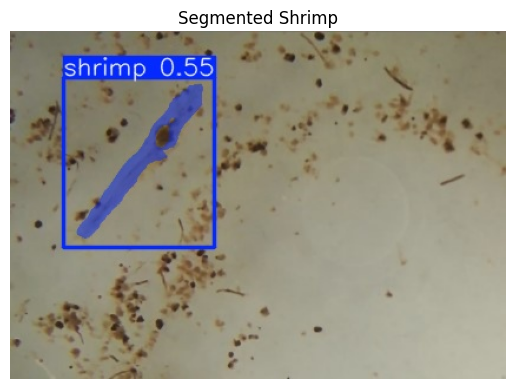

In [51]:
output = "/content/drive/MyDrive/Shrimp_file/output/inference_output/preds"
sample_image = cv2.imread(os.path.join(output, 'IMG_0061.jpg'))
plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
plt.title("Segmented Shrimp")
plt.axis('off')
plt.show()

In [57]:
import matplotlib.pyplot as plt
import cv2
import os


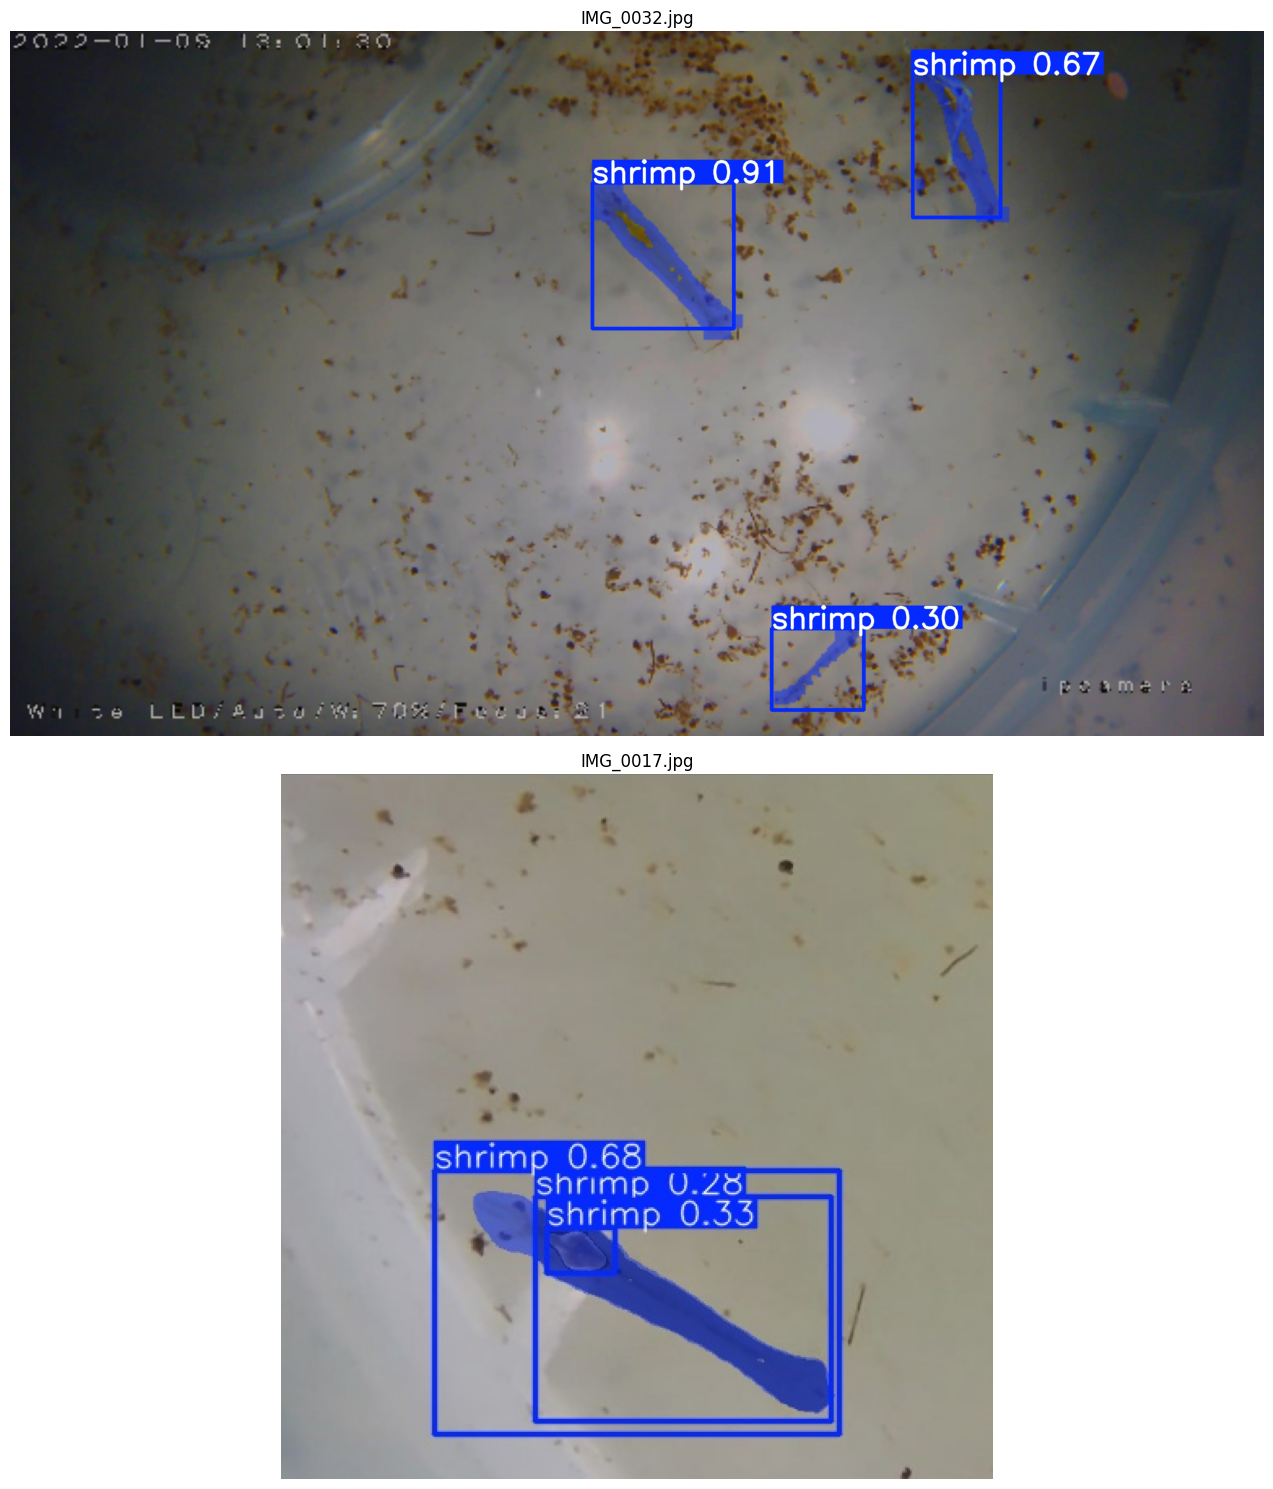

In [56]:
# Folder with validation results
val_result_dir = "/content/drive/MyDrive/Shrimp_file/output/inference_output/preds2"
# List of result images
image_files = [f for f in os.listdir(val_result_dir) if f.endswith(".jpg")]

# Plot the first 4 result images
plt.figure(figsize=(15, 15))
for i, img_file in enumerate(image_files[:2]):
    img_path = os.path.join(val_result_dir, img_file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 1, i+1)
    plt.imshow(img)
    plt.title(img_file)
    plt.axis("off")

plt.tight_layout()
plt.show()
